In [1]:
import pandas as pd
import cv2
import glob

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os, sys, codecs, glob
from PIL import Image, ImageDraw

import numpy as np
import pandas as pd
import cv2

import torch
torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.enabled = False

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

In [3]:
class XunFeiDataset(Dataset):
    def __init__(self, img_path, img_group, transform):
        self.img_path = img_path
        self.transform = transform
        self.group = img_group

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, self.group[index]

    def __len__(self):
        return len(self.img_path)

In [4]:
train_df = pd.read_csv('./电商图像检索_数据集/train.csv')
train_df['path'] = './电商图像检索_数据集/train/' + train_df['name']

train_df['group'] = pd.factorize(train_df['label'])[0]
train_df['fold'] = train_df['group'] % 5

train_df = train_df.sort_values(by='group')
train_df.head(10)

,name,label,path,group,fold
0,008233.jpg,008233.jpg 006688.jpg,./电商图像检索_数据集/train/008233.jpg,0,0
1,006688.jpg,008233.jpg 006688.jpg,./电商图像检索_数据集/train/006688.jpg,0,0
2,000232.jpg,000232.jpg 003552.jpg,./电商图像检索_数据集/train/000232.jpg,1,1
3,003552.jpg,000232.jpg 003552.jpg,./电商图像检索_数据集/train/003552.jpg,1,1
4,000814.jpg,000814.jpg 013765.jpg,./电商图像检索_数据集/train/000814.jpg,2,2
5,013765.jpg,000814.jpg 013765.jpg,./电商图像检索_数据集/train/013765.jpg,2,2
6,001429.jpg,001429.jpg 014834.jpg,./电商图像检索_数据集/train/001429.jpg,3,3
7,014834.jpg,001429.jpg 014834.jpg,./电商图像检索_数据集/train/014834.jpg,3,3
8,012795.jpg,012795.jpg 015860.jpg,./电商图像检索_数据集/train/012795.jpg,4,4
9,015860.jpg,012795.jpg 015860.jpg,./电商图像检索_数据集/train/015860.jpg,4,4


In [5]:
tr_path = train_df[train_df['fold'] != 0]['path'].values
tr_label = train_df[train_df['fold'] != 0]['group']
tr_label = pd.factorize(tr_label)[0]

val_path = train_df[train_df['fold'] == 0]['path'].values
val_label = train_df[train_df['fold'] == 0]['group'].values

In [6]:
tr_label.max()

1805

In [7]:
train_loader = torch.utils.data.DataLoader(
    XunFeiDataset(tr_path, tr_label,
                        transforms.Compose([
                        transforms.Resize((300, 300)),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    ),
    batch_size=10, shuffle=True, num_workers=5,
)

val_loader = torch.utils.data.DataLoader(
    XunFeiDataset(val_path, val_label,
                        transforms.Compose([
                        transforms.Resize((300, 300)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    ),
    batch_size=10, shuffle=False, num_workers=5,
)

In [8]:
class ArcModule(nn.Module):
    def __init__(self, in_features, out_features, s = 10, m = 0.2):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_normal_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = torch.tensor(math.cos(math.pi - m))
        self.mm = torch.tensor(math.sin(math.pi - m) * m)

    def forward(self, inputs, labels):
        cos_th = F.linear(inputs, F.normalize(self.weight))
        cos_th = cos_th.clamp(-1, 1)
        sin_th = torch.sqrt(1.0 - torch.pow(cos_th, 2))
        cos_th_m = cos_th * self.cos_m - sin_th * self.sin_m
        # print(type(cos_th), type(self.th), type(cos_th_m), type(self.mm))
        cos_th_m = torch.where(cos_th > self.th, cos_th_m, cos_th - self.mm)
        
        cond_v = cos_th - self.th
        cond = cond_v <= 0
        cos_th_m[cond] = (cos_th - self.mm)[cond]

        if labels.dim() == 1:
            labels = labels.unsqueeze(-1)
        onehot = torch.zeros(cos_th.size()).cuda()
        labels = labels.type(torch.LongTensor).cuda()
        onehot.scatter_(1, labels, 1.0)
        outputs = onehot * cos_th_m + (1.0 - onehot) * cos_th
        outputs = outputs * self.s
        return outputs

In [9]:
import timm

class XunFeiNet(nn.Module):
    def __init__(self):
        super(XunFeiNet, self).__init__()
                
        model = model = timm.create_model('efficientnet_b2', num_classes=137, 
                          pretrained=True)
        model.classifier = torch.nn.Identity()
        self.model = model
        self.margin = ArcModule(in_features=1408, 
                                out_features = 1806)
        
    def forward(self, img, labels=None):        
        feat = self.model(img)
        
        feat = F.normalize(feat)
        if labels is not None:
            return self.margin(feat, labels)
        return feat
    
model = XunFeiNet().cuda()

In [10]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()

    for i, (input, target) in enumerate(train_loader):
        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        output = model(input, target)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 40 == 0:
            print(loss.item())
            
def validate(val_loader, model):
    model.eval()
    
    val_feats = []
    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda()
            target = target.cuda()

            # compute output
            output = model(input)
            val_feats.append(output.data.cpu().numpy())
    return val_feats

In [11]:
def set_iou(label, predict):
    interset = set(label.split()) &  set(predict.split())
    unionset = set(label.split()) | set(predict.split())
    return len(interset) *1.0 / len(unionset) *1.0

In [12]:
from sklearn.preprocessing import normalize

criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), 0.0003)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.85)
best_acc = 0.0

for epoch in range(20):
    print('Epoch: ', epoch)

    train(train_loader, model, criterion, optimizer, epoch)
    scheduler.step()
    
    val_feats = validate(val_loader, model)
    val_feats = np.vstack(val_feats)
    # val_feats = normalize(val_feats)
    
    val_distance = []
    for feat in val_feats:
        dis = np.dot(feat, val_feats.T)
        val_distance.append(dis)
        
    best_threahold, best_f1 = 0, 0
    for threahold in np.linspace(0.5, 0.99, 20):
        val_submit = []
        for dis in val_distance[:]:
            pred = np.where(dis > threahold)[0]
            if len(pred) == 1:
                ids = dis.argsort()[::-1]
                pred = [x for x in ids[dis[ids] > 0.1]][:2]

            val_submit.append(pred)

        val_f1s = []
        for x, pred in zip(val_label, val_submit):
            label = np.where(val_label == x)[0]
            val_f1 = len(set(pred) & set(label)) / len(set(pred) | set(label)) 
            val_f1s.append(val_f1)

        if best_f1 < np.mean(val_f1s):
            best_f1 = np.mean(val_f1s)
            best_threahold = threahold

    print('Val', best_threahold, best_f1)

Epoch:  0
9.670488357543945
9.727831840515137
9.002659797668457
9.433891296386719
9.519417762756348
9.612276077270508
9.496158599853516
8.945272445678711
9.078862190246582
9.045198440551758
8.466023445129395
8.43017578125
9.007772445678711
8.336748123168945
Val 0.9126315789473685 0.49728474561921193
Epoch:  1
7.787834167480469
8.184675216674805
7.630574703216553
7.9129157066345215
8.150699615478516
8.011946678161621
7.4356889724731445
7.4520087242126465
7.824509620666504
7.054200172424316
6.823802947998047
6.708046913146973
6.767803192138672
7.167276859283447
Val 0.7836842105263158 0.551436823011019
Epoch:  2
6.667402744293213
6.524799346923828
6.1616411209106445
6.7909255027771
6.34220027923584
6.665152072906494
6.660321235656738
6.004796981811523
5.534729957580566
6.864931583404541
6.1565446853637695
5.558651924133301
6.889753818511963
6.449324131011963
Val 0.8094736842105263 0.5881788296302233
Epoch:  3
5.376856327056885
5.12462854385376
4.922795295715332
5.5526933670043945
5.057455

KeyboardInterrupt: 

In [82]:
test_path = glob.glob('./电商图像检索_数据集/test/*')
test_path.sort()
test_path = np.array(test_path)

test_loader = torch.utils.data.DataLoader(
    XunFeiDataset(test_path, [0]*len(test_path),
                        transforms.Compose([
                        transforms.Resize((224, 224)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    ),
    batch_size=50, shuffle=False, num_workers=5,
)

In [83]:
model.eval()
test_feats = []
with torch.no_grad():
    for data in test_loader:
        data = data[0].cuda()
        feat = model(data)
        test_feats.append(feat.data.cpu().numpy())
        
test_feats = np.vstack(test_feats)
test_feats = normalize(test_feats)

In [84]:
test_submit = []
for path, feat in zip(test_path[:], test_feats[:]):
    dis = np.dot(feat, test_feats.T)
    pred = [x.split('/')[-1] for x in test_path[np.where(dis > 0.85)[0]]]
    if len(pred) == 1:
        ids = dis.argsort()[::-1]
        pred = [x.split('/')[-1] for x in test_path[ids[:2]]]
    
    test_submit.append([
        path.split('/')[-1],
        pred
    ])

In [85]:
test_submit = pd.DataFrame(test_submit, columns=['name', 'label'])
test_submit['label'] = test_submit['label'].apply(lambda x: ' '.join(x))
test_submit

,name,label
0,000005.jpg,000005.jpg 012306.jpg
1,000011.jpg,000011.jpg 012317.jpg
2,000012.jpg,000012.jpg 012319.jpg
3,000015.jpg,000015.jpg 000418.jpg
4,000017.jpg,000017.jpg 012331.jpg
...,...,...
4815,016148.jpg,002127.jpg 016148.jpg
4816,016154.jpg,002131.jpg 016154.jpg
4817,016168.jpg,002137.jpg 016168.jpg
4818,016171.jpg,016171.jpg 014843.jpg


In [86]:
test_submit.to_csv('submit.csv',index=None)

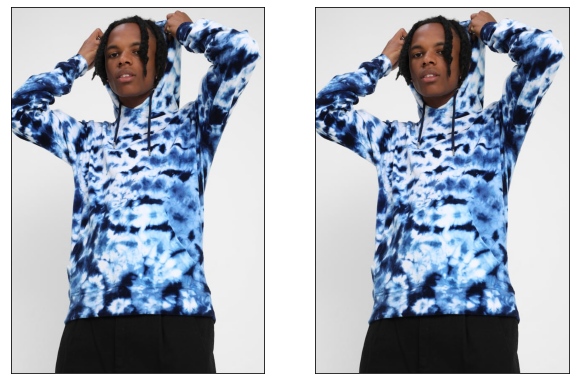

In [319]:
show_image(
    ['./电商图像检索_数据集/test/'+x 
     for x in test_submit['label'].iloc[4].split()]
)

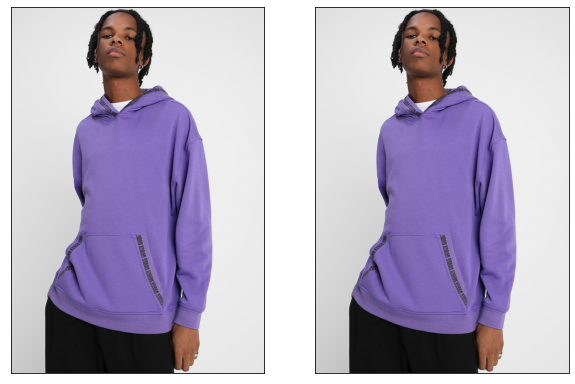

In [310]:
show_image(
    ['./电商图像检索_数据集/test/'+x 
     for x in test_submit['label'].iloc[100].split()]
)